# Лабораторная работа №5: Методы, основанные на деревьях решений. Регрессионные деревья. Деревья классификации. Случайный лес. Бустинг.
## Вариант 9
## ПМИ3-1 Гущина Ольга
<p style="text-indent: 40px"><strong>Данные:</strong> winequalityred_for_lab</p>
<p style="text-indent: 40px"><strong>Зависимая переменная:</strong> Y</p>
<p style="text-indent: 40px"><strong>Объясняющие переменные:</strong></p>

<ul style="margin-left: 60px">
<li>fixed_acidity</li>
<li>volatile_acidity</li>
<li>citric_acid</li>
<li>residual_sugar</li>
<li>chlorides</li>
<li>free_sulfur_dioxide</li>
<li>total_sulfur_dioxide</li>
<li>density</li>
<li>pH</li>
<li>sulphates</li>
<li>alcohol</li>
</ul>

<p style="text-indent: 40px"><strong>Метод:</strong> Бустинг</p>

In [19]:
# Настройка ширины страницы блокнота
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Загружаем пакеты
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from pathlib import Path
from IPython.display import Markdown, display
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from scipy.stats import chi2_contingency
import time

# загрузка пакетов: данные ---
from sklearn import datasets

# загрузка пакетов: модели ---
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
# константы
my_seed = 9  # номер варианта
plt = mpl.pyplot
sns.set_palette("Set2")

# функция форматирования результатов с использованием Markdown
def printmd(string):
    display(Markdown(string))

# функция, которая строит график важности признаков
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title('Важность признаков в модели: ' + model_type)
    plt.xlabel('Важность признака')
    plt.ylabel('')
    plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_8720\203097248.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


Загружаем данные во фрейм и выясняем их размерность.

In [20]:
# Загружаем данные
fileURL = 'https://raw.githubusercontent.com/ania607/ML/refs/heads/main/data/winequality-red_for_lab.csv'
DF_all = pd.read_csv(fileURL)

# оставляем в наборе данных только столбцы по варианту
DF_all = DF_all[['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
                 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 
                 'pH', 'sulphates', 'alcohol', 'Y']].copy()

# Разделяем данные на обучающую (85%) и тестовую (15%) выборки
DF = DF_all.sample(frac=0.85, random_state=my_seed)
DF_predict = DF_all.drop(DF.index)

print('Число строк в обучающей выборке:', DF.shape[0])
print('Число строк в отложенной выборке:', DF_predict.shape[0])

Число строк в обучающей выборке: 1359
Число строк в отложенной выборке: 240


Построим дерево с обрезкой ветвей.

In [21]:
# Создаем матрицу признаков и вектор целевой переменной
X = DF.drop('Y', axis=1)
y = DF['Y']
X_pred = DF_predict.drop('Y', axis=1)
y_true = DF_predict['Y']

# Сначала строим полное дерево
cls_one_tree = DecisionTreeClassifier(criterion='entropy', random_state=my_seed)
tree_full = cls_one_tree.fit(X, y)

print(f'Количество листьев в полном дереве: {tree_full.get_n_leaves()}')
print(f'Глубина полного дерева: {tree_full.get_depth()}')

Количество листьев в полном дереве: 211
Глубина полного дерева: 18


In [22]:
# Подбор оптимального параметра обрезки
path = cls_one_tree.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

print(f'Всего значений alpha: {len(ccp_alphas)}')

Всего значений alpha: 137


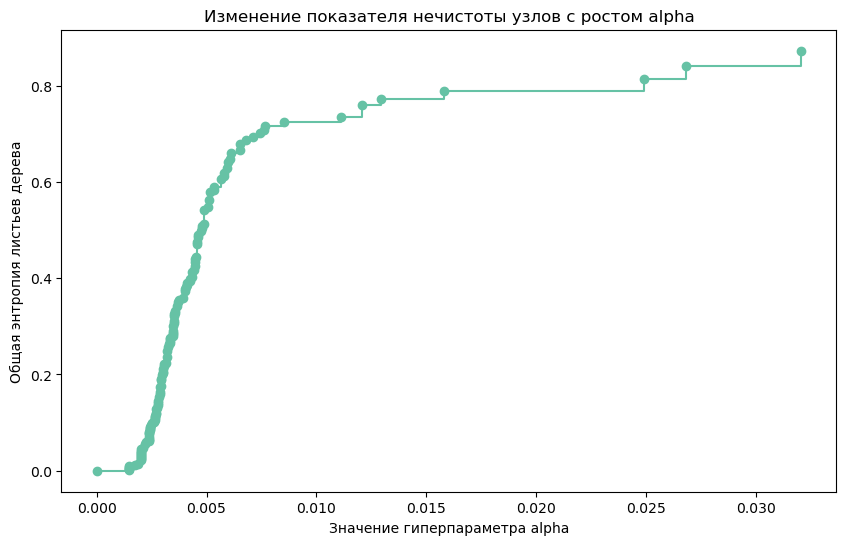

In [23]:
# График изменения энтропии с ростом alpha
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("Значение гиперпараметра alpha")
plt.ylabel("Общая энтропия листьев дерева")
plt.title("Изменение показателя нечистоты узлов с ростом alpha")
plt.show()

In [24]:
# Обучаем деревья с разными alpha
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=my_seed, test_size=0.3)

clfs = []
node_counts = []
train_scores = []
test_scores = []
print("Обучение деревьев с разными alpha...")
tic = time.perf_counter()
for ccp_alpha in ccp_alphas:
    try:
        clf = DecisionTreeClassifier(random_state=my_seed, ccp_alpha=ccp_alpha)
        clf.fit(X_train, y_train)
        clfs.append(clf)
        node_counts.append(clf.tree_.node_count)
        train_scores.append(clf.score(X_train, y_train))
        test_scores.append(clf.score(X_test, y_test))
    except Exception as e:
        print(f"Ошибка при alpha={ccp_alpha}: {e}")
        continue

toc = time.perf_counter()
print(f"Обучение заняло {toc - tic:0.2f} секунд")
print(f"Успешно обучено {len(clfs)} деревьев")

Обучение деревьев с разными alpha...
Обучение заняло 2.60 секунд
Успешно обучено 137 деревьев


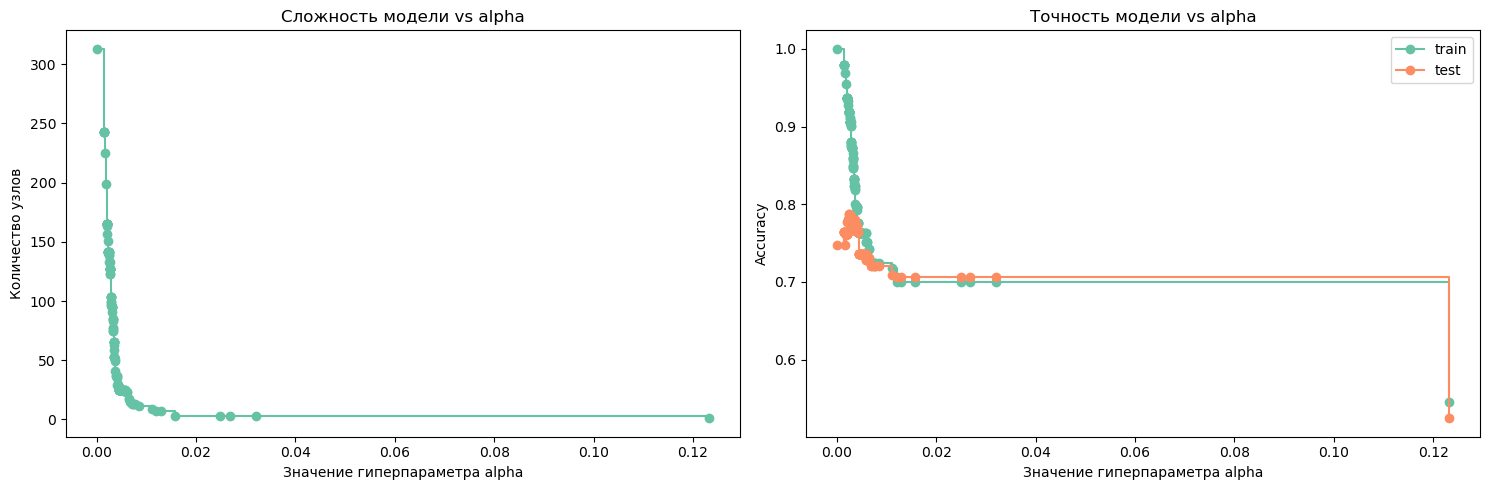

In [25]:
# Проверяем, что у нас есть данные для графиков
if len(clfs) > 0:
    # Графики сложности модели и точности
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    # График глубины дерева
    ax[0].plot(ccp_alphas[:len(node_counts)], node_counts, marker='o', drawstyle="steps-post")
    ax[0].set_xlabel("Значение гиперпараметра alpha")
    ax[0].set_ylabel("Количество узлов")
    ax[0].set_title("Сложность модели vs alpha")

    # График точности
    ax[1].plot(ccp_alphas[:len(train_scores)], train_scores, marker='o', label='train', drawstyle="steps-post")
    ax[1].plot(ccp_alphas[:len(test_scores)], test_scores, marker='o', label='test', drawstyle="steps-post")
    ax[1].set_xlabel("Значение гиперпараметра alpha")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_title("Точность модели vs alpha")
    ax[1].legend()
    plt.tight_layout()
    plt.show()

In [26]:
# Находим оптимальное дерево
optimal_idx = np.argmax(test_scores)
optimal_alpha = ccp_alphas[optimal_idx]
optimal_nodes = node_counts[optimal_idx]

print(f'Оптимальное количество узлов: {optimal_nodes}')
print(f'Оптимальное значение alpha: {optimal_alpha:.6f}')
print(f'Acc на тестовой выборке: {test_scores[optimal_idx]:.3f}')

Оптимальное количество узлов: 139
Оптимальное значение alpha: 0.002469
Acc на тестовой выборке: 0.787


In [27]:
# Будем сохранять точность моделей
score = []
score_models = []

# Точность полного дерева с перекрёстной проверкой
cv_full = cross_val_score(estimator=cls_one_tree, X=X, y=y, cv=5, scoring='accuracy')
score.append(np.around(np.mean(cv_full), 3))
score_models.append('full_tree')
print(f'Acc полного дерева с перекрёстной проверкой: {score[0]}')

Acc полного дерева с перекрёстной проверкой: 0.746


In [28]:
# Точность оптимального дерева с перекрёстной проверкой
optimal_tree = clfs[optimal_idx]
cv_pruned = cross_val_score(estimator=optimal_tree, X=X, y=y, cv=5, scoring='accuracy')
score.append(np.around(np.mean(cv_pruned), 3))
score_models.append('pruned_tree')
print(f'Acc обрезанного дерева с перекрёстной проверкой: {score[1]}')

Acc обрезанного дерева с перекрёстной проверкой: 0.75


### Бустинг

In [29]:
# Сначала тестируем модель с параметрами по умолчанию
gb_default = GradientBoostingClassifier(random_state=my_seed)
cv_default = cross_val_score(gb_default, X, y, cv=5, scoring='accuracy')
print(f'Acc бустинга с параметрами по умолчанию: {np.mean(cv_default):.3f}')

Acc бустинга с параметрами по умолчанию: 0.777


In [30]:
# Сеточный поиск для бустинга
param_grid = {
    'n_estimators': [10, 20, 30, 40, 50, 60, 70],  # 7 значений
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],  # 7 значений
    'max_depth': [1, 2, 3, 4, 5, 6, 7]  # 7 значений
}

print("Запуск сеточного поиска для бустинга...")
tic = time.perf_counter()

kfold = KFold(n_splits=5, random_state=my_seed, shuffle=True)
gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=my_seed),
    param_grid,
    scoring='accuracy',
    cv=kfold,
    n_jobs=-1
)

gb_grid.fit(X, y)
toc = time.perf_counter()

print(f'Сеточный поиск занял {toc - tic:.2f} секунд')

# Результаты сеточного поиска
best_gb = gb_grid.best_estimator_
best_params = gb_grid.best_params_

print(f'Лучшие параметры бустинга:')
print(f'  n_estimators: {best_params["n_estimators"]}')
print(f'  learning_rate: {best_params["learning_rate"]}')
print(f'  max_depth: {best_params["max_depth"]}')
print(f'Acc лучшей модели бустинга: {gb_grid.best_score_:.3f}')

score.append(np.around(gb_grid.best_score_, 3))
score_models.append('boosting_GS')

Запуск сеточного поиска для бустинга...
Сеточный поиск занял 108.19 секунд
Лучшие параметры бустинга:
  n_estimators: 50
  learning_rate: 0.1
  max_depth: 6
Acc лучшей модели бустинга: 0.808


Найдем важность признаков.


График важности признаков в модели бустинга:


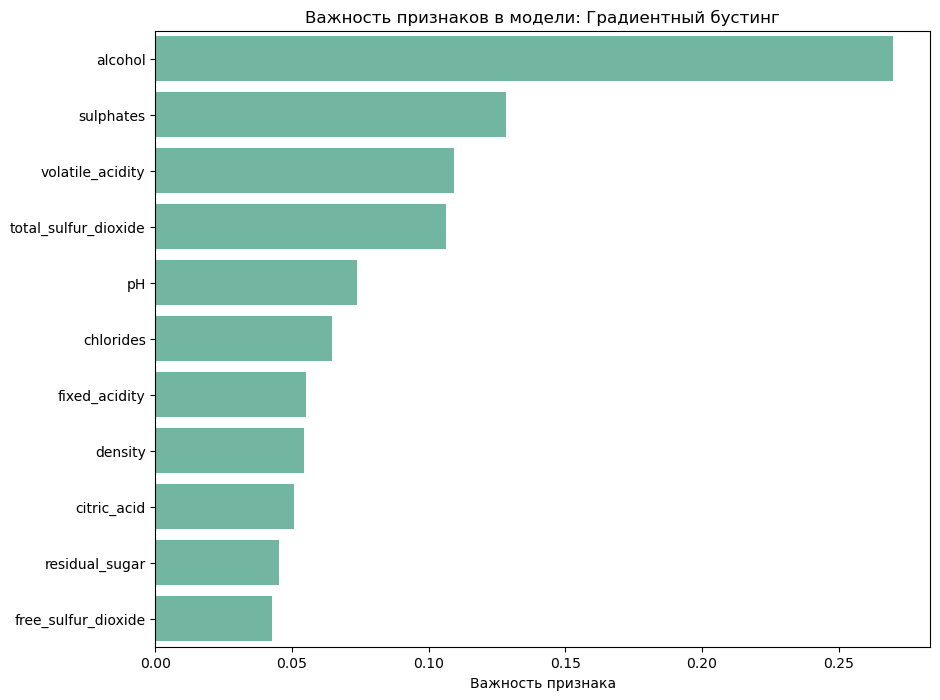

In [31]:
# Важность признаков в бустинге
print("\nГрафик важности признаков в модели бустинга:")
plot_feature_importance(best_gb.feature_importances_, X.columns, 'Градиентный бустинг')

Сравнение моделей и выбор лучшей.

In [32]:
results_df = pd.DataFrame({
    'Модель': score_models,
    'Acc': score
})

print(results_df)

# Выбираем лучшую модель
best_model_idx = np.argmax(score)
best_model_name = score_models[best_model_idx]
best_model_acc = score[best_model_idx]

print(f'\nЛучшая модель: {best_model_name} с Acc = {best_model_acc}')

if best_model_name == 'pruned_tree':
    best_model = optimal_tree
elif best_model_name == 'boosting_GS':
    best_model = best_gb
else:
    best_model = cls_one_tree

        Модель    Acc
0    full_tree  0.746
1  pruned_tree  0.750
2  boosting_GS  0.808

Лучшая модель: boosting_GS с Acc = 0.808


Прогноз на отложенные наблюдения.

Отчёт о классификации на отложенных наблюдениях:
              precision    recall  f1-score   support

           0       0.79      0.72      0.76       118
           1       0.75      0.82      0.78       122

    accuracy                           0.77       240
   macro avg       0.77      0.77      0.77       240
weighted avg       0.77      0.77      0.77       240



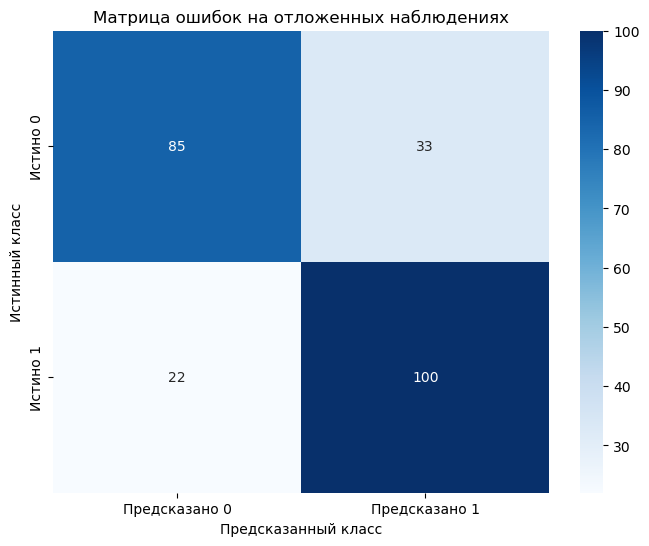

In [33]:
# Переобучим лучшую модель на всех обучающих данных
if best_model_name == 'pruned_tree':
    best_model_final = DecisionTreeClassifier(
        random_state=my_seed, 
        ccp_alpha=optimal_alpha
    ).fit(X, y)
elif best_model_name == 'boosting_GS':
    best_model_final = GradientBoostingClassifier(
        **best_params,
        random_state=my_seed
    ).fit(X, y)
else:
    best_model_final = best_model

# Прогноз
y_pred = best_model_final.predict(X_pred)

# Оценка точности
print("Отчёт о классификации на отложенных наблюдениях:")
print(classification_report(y_true, y_pred))

# Матрица ошибок
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Предсказано 0', 'Предсказано 1'],
            yticklabels=['Истино 0', 'Истино 1'])
plt.title('Матрица ошибок на отложенных наблюдениях')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

Сравнение с моделью из предыдущей лабораторной работы.

In [34]:
print("Результаты из лабораторной работы №4:")
prev_results = pd.DataFrame({
    'Модель': ['logit_PC2', 'logit_ridge'],
    'Acc': [0.642, 0.734]
})
print(prev_results)

print(f"\nТочность лучшей модели из текущей работы: {best_model_acc}")

if best_model_acc > 0.734:
    print("Текущая модель показывает ЛУЧШУЮ точность по сравнению с моделями из лабораторной №4")
elif best_model_acc == 0.734:
    print("Текущая модель показывает ОДИНАКОВУЮ точность с лучшей моделью из лабораторной №4")
else:
    print("Текущая модель показывает ХУДШУЮ точность по сравнению с моделями из лабораторной №4")

# Дополнительная информация о лучшей модели
print("\n" + "="*50)
print("ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ О ЛУЧШЕЙ МОДЕЛИ")
print("="*50)

if best_model_name == 'pruned_tree':
    print(f"Глубина дерева: {best_model_final.get_depth()}")
    print(f"Количество листьев: {best_model_final.get_n_leaves()}")
    print(f"Параметр обрезки alpha: {optimal_alpha:.6f}")
elif best_model_name == 'boosting_GS':
    print(f"Количество деревьев: {best_params['n_estimators']}")
    print(f"Скорость обучения: {best_params['learning_rate']}")
    print(f"Максимальная глубина: {best_params['max_depth']}")
    
    # Важность признаков в табличном виде
    feature_importance = pd.DataFrame({
        'Признак': X.columns,
        'Важность': best_model_final.feature_importances_
    }).sort_values('Важность', ascending=False)
    
    print("\nТаблица важности признаков в лучшей модели бустинга:")
    print(feature_importance)

Результаты из лабораторной работы №4:
        Модель    Acc
0    logit_PC2  0.642
1  logit_ridge  0.734

Точность лучшей модели из текущей работы: 0.808
Текущая модель показывает ЛУЧШУЮ точность по сравнению с моделями из лабораторной №4

ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ О ЛУЧШЕЙ МОДЕЛИ
Количество деревьев: 50
Скорость обучения: 0.1
Максимальная глубина: 6

Таблица важности признаков в лучшей модели бустинга:
                 Признак  Важность
10               alcohol  0.270022
9              sulphates  0.128168
1       volatile_acidity  0.109209
6   total_sulfur_dioxide  0.106167
8                     pH  0.073762
4              chlorides  0.064739
0          fixed_acidity  0.055076
7                density  0.054266
2            citric_acid  0.050899
3         residual_sugar  0.045168
5    free_sulfur_dioxide  0.042524
